# DETR 학습

In [1]:
import os
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random
from transformers import DetrImageProcessor, DetrForObjectDetection, TrainingArguments, Trainer

In [2]:
class CVATDetrDataset(Dataset):
    def __init__(self, image_dir, annotation_file, processor, transform=None):
        """
        Args:
            image_dir (str): 이미지가 저장된 폴더 경로
            annotation_file (str): annotations.xml 파일 경로
            processor: Hugging Face DetrImageProcessor
        """
        self.image_dir = image_dir
        self.processor = processor
        self.transform = transform
        
        # 1. XML 파싱 및 클래스 정의
        self.label2id = {"ripe_chamoe": 0} # 현재 XML에는 'ripe_chamoe'만 보입니다.
        self.id2label = {0: "ripe_chamoe"}
        
        self.samples = self._parse_xml(annotation_file)

    def _parse_xml(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        samples = []
        
        # <image> 태그를 순회합니다.
        for image_tag in root.findall('image'):
            file_name = image_tag.get('name')
            width = int(image_tag.get('width'))
            height = int(image_tag.get('height'))
            
            boxes = []
            class_labels = []
            
            # 해당 이미지 내의 <box> 태그를 순회합니다.
            for box in image_tag.findall('box'):
                label_name = box.get('label')
                if label_name not in self.label2id:
                    continue # 정의되지 않은 라벨은 건너뜀
                
                # CVAT XML 좌표: xtl, ytl, xbr, ybr -> x_min, y_min, x_max, y_max
                xtl = float(box.get('xtl'))
                ytl = float(box.get('ytl'))
                xbr = float(box.get('xbr'))
                ybr = float(box.get('ybr'))
                
                # 유효성 검사 (너비나 높이가 0보다 커야 함)
                if xbr > xtl and ybr > ytl:
                    boxes.append([xtl, ytl, xbr, ybr])
                    class_labels.append(self.label2id[label_name])
            
            # 박스가 없어도(빈 리스트여도) 데이터셋에 추가합니다 (Negative Sample)
            samples.append({
                "file_name": file_name,
                "boxes": boxes,
                "class_labels": class_labels,
                "orig_size": (height, width)
            })
            
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        image_path = os.path.join(self.image_dir, item['file_name'])
        
        # 이미지 로드 및 RGB 변환
        image = Image.open(image_path).convert("RGB")

        # --- [핵심 수정 부분] Processor를 위한 COCO 포맷 변환 ---
        # DetrImageProcessor는 annotations 인자를 받을 때 COCO 포맷을 기대합니다.
        # 구조: {'image_id': int, 'annotations':List[Dict]}
        # Dict 내부: {'bbox': [x, y, w, h], 'category_id': int, ...}
        
        formatted_annotations = []
        
        for box, label in zip(item['boxes'], item['class_labels']):
            # 저장된 box는 [x_min, y_min, x_max, y_max] 형태
            x_min, y_min, x_max, y_max = box
            
            # COCO 포맷은 [x_min, y_min, width, height] 입니다.
            width = x_max - x_min
            height = y_max - y_min
            
            formatted_annotations.append({
                "id": idx, # 임의의 ID
                "image_id": idx,
                "category_id": label,
                "bbox": [x_min, y_min, width, height], # xywh 변환!
                "area": width * height,
                "iscrowd": 0
            })
        
        target = {'image_id': idx, 'annotations': formatted_annotations}

        # Processor 실행
        # processor가 내부적으로:
        # 1. 이미지를 리사이징하고 정규화합니다.
        # 2. 'bbox' 좌표도 이미지 리사이징 비율에 맞춰 자동으로 변환합니다.
        # 3. 최종적으로 모델 학습에 필요한 (cx, cy, w, h) 정규화된 좌표로 변환해줍니다.
        encoding = self.processor(images=image, annotations=target, return_tensors="pt")
        
        pixel_values = encoding["pixel_values"].squeeze() 
        target = encoding["labels"][0] # 변환된 labels 가져오기

        return {"pixel_values": pixel_values, "labels": target}

In [3]:
# --- 데이터 로드 테스트 코드 ---

# 사전 학습된 모델의 체크포인트 이름
CHECKPOINT = "facebook/detr-resnet-50"

# 1. Processor 로드
processor = DetrImageProcessor.from_pretrained(CHECKPOINT)

# 2. 데이터셋 인스턴스 생성 (경로를 실제 환경에 맞게 수정해주세요)
# 예: image_dir="./images", annotation_file="./annotations.xml"
# 여기서는 클래스 동작 확인을 위해 경로는 임의로 지정합니다.
BASE_DIR = "/home/leedh/바탕화면/EDL_exp/dataset_cvat"
dataset = CVATDetrDataset(
    image_dir=f"{BASE_DIR}/images",  # 실제 이미지가 있는 폴더 경로
    annotation_file=f"{BASE_DIR}/annotations.xml", # 제공해주신 xml 파일 경로
    processor=processor
)

# 3. 첫 번째 데이터 확인
if len(dataset) > 0:
    sample = dataset[0]
    print(f"데이터셋 크기: {len(dataset)}")
    print(f"이미지 텐서 크기: {sample['pixel_values'].shape}")
    print(f"라벨 정보: {sample['labels']}")
else:
    print("데이터셋이 비어있거나 경로가 잘못되었습니다.")

데이터셋 크기: 398
이미지 텐서 크기: torch.Size([3, 1066, 800])
라벨 정보: {'size': tensor([1066,  800]), 'image_id': tensor([0]), 'class_labels': tensor([0, 0]), 'boxes': tensor([[0.4671, 0.3019, 0.1507, 0.1298],
        [0.2898, 0.6961, 0.2983, 0.2846]]), 'area': tensor([16686.7109, 72400.7891]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([4032, 3024])}


## --- 실행 준비 ---

In [4]:
# 1. 모델 로드
# 체크포인트는 데이터셋 만들 때 썼던 것과 동일해야 합니다.
model = DetrForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=dataset.id2label,
    label2id=dataset.label2id,
    ignore_mismatched_sizes=True, # 기존 모델(COCO 80클래스)과 우리 클래스 개수(1개)가 다르므로 허용
)

# 2. Data Collator (배치 처리 함수) 정의
# 배치 내의 이미지들을 가장 큰 이미지 크기에 맞춰 패딩(Padding)하고 마스크를 생성합니다.
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    labels = [item["labels"] for item in batch]
    
    # 프로세서의 pad 기능을 사용하여 배치 내 이미지 크기를 맞춥니다.
    # return_tensors="pt" : 파이토치 텐서로 반환
    batch_encoding = dataset.processor.pad(pixel_values, return_tensors="pt")
    
    return {
        "pixel_values": batch_encoding["pixel_values"],
        "pixel_mask": batch_encoding["pixel_mask"], # DETR은 패딩된 부분을 무시하기 위해 마스크가 필요합니다.
        "labels": labels
    }

# 3. 학습 인자 설정 (Hyperparameters)
training_args = TrainingArguments(
    output_dir="./runs/detr-chamoe-result", # 결과 저장 경로
    per_device_train_batch_size=8,     # 배치 사이즈 (GPU 메모리에 따라 조절: 2, 4, 8...)
    num_train_epochs=10,               # 학습 횟수 (실험용이니 적게 설정, 실제론 50~100 이상 권장)
    fp16=torch.cuda.is_available(),    # GPU가 있으면 가속 기능 사용
    save_steps=50,                     # 50 step마다 모델 저장
    logging_steps=10,                  # 10 step마다 로그 출력
    learning_rate=1e-5,                # 학습률 (DETR은 낮게 잡는 것이 좋습니다)
    weight_decay=1e-4,                 # 과적합 방지
    save_total_limit=2,                # 저장 공간 절약을 위해 최근 모델 2개만 남김
    remove_unused_columns=False,       # 우리가 만든 커스텀 컬럼을 지우지 않도록 설정
    dataloader_pin_memory=True,        # 가끔 윈도우/맥 환경에서 오류 날 때 끔 (리눅스는 True 추천)
)

# 4. Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset,
)

/home/leedh/bin/miniconda3/envs/edl/lib/python3.10/site-packages/torch/nn/modules/module.py:2409: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/leedh/bin/miniconda3/envs/edl/lib/python3.10/site-packages/torch/nn/modules/module.py:2409: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/leedh/bin/miniconda3/envs/edl/lib/python3.10/site-packages/torch/nn/modules/module.py:2409: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a 

In [5]:
# 5. 학습 시작!
print("학습을 시작합니다...")
trainer.train()

학습을 시작합니다...


Step,Training Loss
10,1.389800
20,1.196200
30,1.198100
40,1.106600
50,0.930500
60,0.852700
70,0.887700
80,0.891600
90,0.764100
100,0.884400


TrainOutput(global_step=500, training_loss=0.7219240961074829, metrics={'train_runtime': 1313.491, 'train_samples_per_second': 3.03, 'train_steps_per_second': 0.381, 'total_flos': 3.287592365333179e+18, 'train_loss': 0.7219240961074829, 'epoch': 10.0})

## 학습 잘 되었는가 확인 (시각화)

테스트 이미지: ./dataset_cvat/images/image0236.png

탐지 결과:
Detect: ripe_chamoe with 0.62 at [196.46, 2627.84, 455.39, 2899.34]
Detect: ripe_chamoe with 0.672 at [439.31, 797.06, 870.98, 1283.6]
Detect: ripe_chamoe with 0.644 at [995.53, 1221.01, 1234.01, 1491.83]


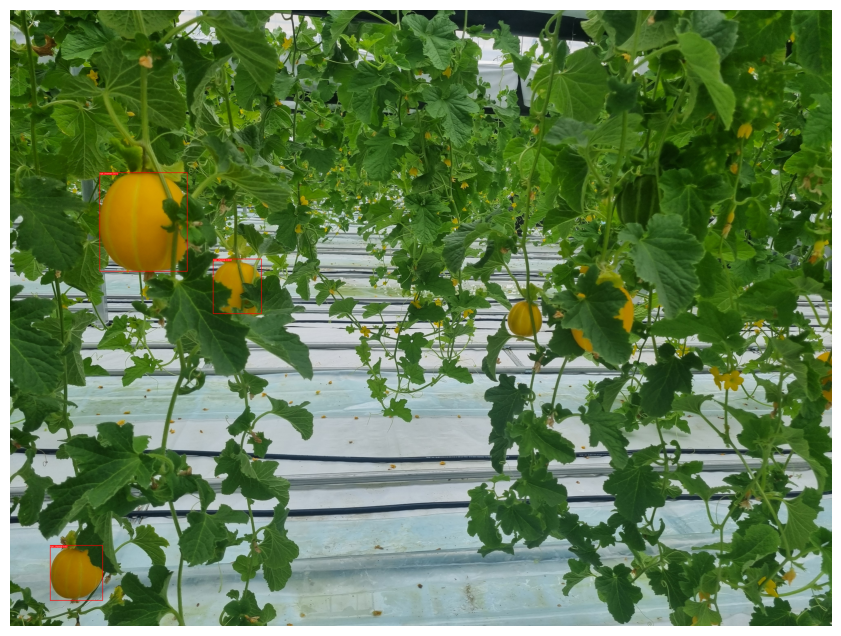

In [4]:
# 1. 학습된 모델과 프로세서 불러오기
# 학습이 끝난 output_dir 경로를 지정해주세요. (예: 가장 마지막 체크포인트 폴더)
# 보통 trainer.train()이 끝나면 './detr-chamoe-result'에 저장되지만,
# 안전하게 특정 체크포인트(예: checkpoint-1000)를 지정하는 것이 좋습니다.
MODEL_PATH = "./runs/detr-chamoe-result/checkpoint-500" 

# 만약 체크포인트 폴더가 없다면 trainer.save_model("./final_model")로 저장한 경로를 쓰셔도 됩니다.
if not os.path.exists(MODEL_PATH):
    print(f"경로를 찾을 수 없습니다: {MODEL_PATH}")
    # 경로가 없다면 임시로 가장 최신 폴더를 찾습니다.
    checkpoints = sorted([d for d in os.listdir("./detr-chamoe-result") if "checkpoint" in d], key=lambda x: int(x.split('-')[1]))
    if checkpoints:
        MODEL_PATH = os.path.join("./detr-chamoe-result", checkpoints[-1])
        print(f"가장 최신 체크포인트로 대체합니다: {MODEL_PATH}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 모델과 프로세서 로드 (수정된 부분!)
# 모델 가중치는 우리가 학습시킨 체크포인트에서 가져옵니다.
model = DetrForObjectDetection.from_pretrained(MODEL_PATH).to(device)

# 프로세서는 학습 전과 설정이 똑같으므로, 원본 설정을 그대로 가져옵니다.
# 이렇게 하면 preprocessor_config.json 파일이 없다는 에러를 피할 수 있습니다.
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# 3. 테스트할 이미지 선택 (랜덤하게 하나 뽑기)
image_dir = "./dataset_cvat/images"  # 이미지가 있는 폴더
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
test_image_path = os.path.join(image_dir, random.choice(image_files))

image = Image.open(test_image_path).convert("RGB")
print(f"테스트 이미지: {test_image_path}")

# 4. 추론 (Inference)
# 전처리
inputs = processor(images=image, return_tensors="pt").to(device)

# 모델 예측
with torch.no_grad():
    outputs = model(**inputs)

# 5. 후처리 (Post-processing)
# 모델 출력(x,y,w,h)을 이미지 크기에 맞는 좌표(x_min, y_min, x_max, y_max)로 변환
target_sizes = torch.tensor([image.size[::-1]]) # (height, width) 순서
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

# 6. 시각화 (Bounding Box 그리기)
draw = ImageDraw.Draw(image)

# 폰트 설정 (폰트 파일이 없으면 기본 폰트 사용)
try:
    font = ImageFont.truetype("arial.ttf", 20) # 윈도우/리눅스 환경에 따라 폰트 경로 수정 필요할 수 있음
except:
    font = load_default_font = ImageFont.load_default()

print("\n탐지 결과:")
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    # 박스 좌표를 소수점에서 정수로 변환
    box = [round(i, 2) for i in box.tolist()]
    x_min, y_min, x_max, y_max = box
    
    # 결과 출력
    print(
        f"Detect: {model.config.id2label[label.item()]} "
        f"with {round(score.item(), 3)} at {box}"
    )
    
    # 박스 그리기
    draw.rectangle((x_min, y_min, x_max, y_max), outline="red", width=3)
    
    # 텍스트(라벨 + 점수) 그리기
    text = f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}"
    
    # 텍스트 배경 박스 (가독성을 위해)
    text_bbox = draw.textbbox((x_min, y_min), text, font=font)
    draw.rectangle(text_bbox, fill="red")
    draw.text((x_min, y_min), text, fill="white", font=font)

# 7. 결과 이미지 출력
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

## (번외) 나중에 참고 할 거
> 검증 과정 추가하여 학습하기

In [ ]:
from torch.utils.data import random_split

# 1. 전체 데이터셋 불러오기 (기존 코드)
full_dataset = CVATDetrDataset(
    image_dir="./dataset_cvat/images",
    annotation_file="./dataset_cvat/annotations.xml",
    processor=processor
)

# 2. 학습용(Train) vs 검증용(Validation) 나누기 (예: 80% vs 20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# random_split을 사용하면 무작위로 섞어서 나눠줍니다.
train_dataset, eval_dataset = random_split(full_dataset, [train_size, val_size])

print(f"전체 데이터: {len(full_dataset)}장")
print(f"학습용(Train): {len(train_dataset)}장")
print(f"검증용(Eval): {len(eval_dataset)}장")

# 3. Trainer 설정 수정
training_args = TrainingArguments(
    output_dir="./detr-chamoe-experiment",
    per_device_train_batch_size=2,
    num_train_epochs=30,             # Epoch 수를 좀 늘려봅시다.
    fp16=True,
    save_steps=100,
    logging_steps=10,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    
    # [추가된 부분] 검증 설정
    eval_strategy="epoch",           # 매 Epoch가 끝날 때마다 검증(평가) 수행
    save_strategy="epoch",           # 매 Epoch마다 저장 (평가 시점과 맞춤)
    load_best_model_at_end=True,     # 학습이 다 끝나면, 가장 성능 좋았던 모델을 불러옴
    metric_for_best_model="eval_loss", # 'eval_loss'가 가장 낮은 것을 Best로 선정 (아직 mAP 코드가 없으므로)
    greater_is_better=False,         # Loss는 낮을수록 좋으므로 False
)

# 4. Trainer에 eval_dataset 추가
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,     # 80% 데이터
    eval_dataset=eval_dataset,       # 20% 데이터 (채점용)
)

# 5. 학습 시작
trainer.train()

In [ ]:
## 최종 테스트용 검증 코드

# ... (앞부분 학습 코드 동일) ...

# 5. 학습 시작
trainer.train()

# ---------------------------------------------------------
# [추가된 프로세스] 6. 최종 테스트 (Test)
# ---------------------------------------------------------
print("\n=== 최종 테스트 시작 (Test Set) ===")

# 1) Best Model 로드 확인
# training_args에서 load_best_model_at_end=True로 설정했다면
# 현재 trainer.model은 이미 '검증(Valid)' 기준 1등 모델입니다.

# 2) 테스트 데이터셋으로 평가 실행
# 이때 나오는 결과는 학습 과정에서 모델이 단 한 번도 보지 못한 데이터에 대한 결과입니다.
test_results = trainer.evaluate(test_dataset)

print(f"최종 테스트 Loss: {test_results['eval_loss']}")
# 만약 mAP 계산 함수(compute_metrics)를 넣었다면 여기서 mAP도 같이 출력됩니다.